In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib
import math

from strategy import strategies
from feature_engineering import feature_functions

feature_engineer = feature_functions["15_dir"]
feature_engineer_vol =  feature_functions["15_dir"]
# get_quotes = strategies["15_regr"]
get_quotes = strategies["strategy:1.0"]

/Users/joeybesseling/Documents/Programmeren/Projects/DeribitArbitrage/deribit-marketmaker-rest/strategy.py:6: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_quotes2(data, params):
/Users/joeybesseling/Documents/Programmeren/Projects/DeribitArbitrage/deribit-marketmaker-rest/strategy.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def test_strategy(da

# Feature Engineer

In [2]:
def process_data(df):
    features = feature_engineer(df)

    mid = (df["bid1_price"] + df["ask1_price"])/2
    mid = mid.apply(np.log).diff().shift(-1)
    targets = mid
    return features, targets

# Open data and "clean"

In [90]:
found = True
i = 0
exclude = []

feature_frames = []
target_frames = []
full_df_frames = []
df_frames = []

instrument = "ETH-PERPETUAL"

path = f"{instrument}/"
instrument = f"{instrument}"
interval = 1
depth = 20

for i in range(10,11): # 350-660 # 1 - 880
    df = pd.read_parquet(path + f"{instrument}_1_{depth}({i}).csv")
    df["timestamp"] = pd.to_datetime(df.timestamp)
    df = df.set_index("timestamp", drop = True)
    df = df.drop("Unnamed: 0", axis = 1)
    if interval > 1:
        for column in df.columns:
            if "trade" in column:
                df[column] = df[column].rolling(interval).sum()
    df["min_bid"] = df.bid1_price.rolling(interval).min()
    df["max_ask"] = df.ask1_price.rolling(interval).max()
    df = df.resample(f"{interval}s").last()
    df["min_bid"] = df["min_bid"].shift(-1)
    df["max_ask"] = df["max_ask"].shift(-1)
    features, targets = process_data(df)
    
    features = features[targets.notna()]
    df = df[targets.notna()]
    targets = targets[targets.notna()]

    df_frames.append(df)
    feature_frames.append(features)
    target_frames.append(targets)
df = pd.concat(df_frames)
full_dfs = df.copy()
# feature_frames.append(features.copy())
# target_frames.append(targets.copy())
# full_df_frames.append(df)

In [91]:
# model = joblib.load(f"models/{instrument}_model_{interval}s_regr.joblib")
model_vol = joblib.load(f"models/{instrument}_model_{interval}s_vol.joblib")

prediction_vol = pd.DataFrame({"prediction_vol": model_vol.predict(features)})
prediction_vol.index = features.index
full_df = pd.merge(full_dfs, prediction_vol, left_index=True, right_index=True)
prediction = prediction_vol.copy()
# prediction = pd.DataFrame({"prediction": prediction.values()})
prediction["prediction"] = prediction["prediction_vol"]
prediction[prediction!= 0] = 0
prediction.index = features.index
full_df = pd.merge(full_df, prediction["prediction"], left_index = True, right_index = True)


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from math import log

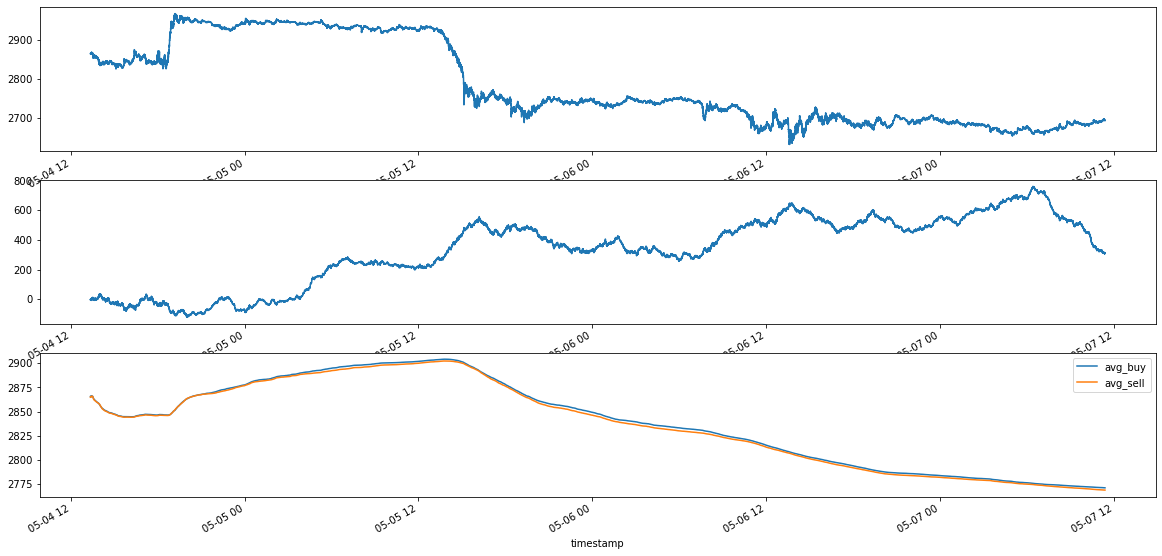

Total volume: 74550.0


In [94]:
# first add quotation to each line on pandas
def compute_bid(series: pd.Series):
    return series["bid1_price"] - max((math.log(series["prediction_vol"], 10) + 8),0)

def compute_ask(series: pd.Series):
    return series["ask1_price"] + max((math.log(series["prediction_vol"], 10) + 8),0)

def check_bid_filled(series):
    if series["bid_quote"] > series["min_bid"]:
        return +1
    else:return float("NaN")

def check_ask_filled(series):
    if series["ask_quote"] < series["max_ask"]:
        return +1
    else:return float("NaN")

def simulate(full_df, plot = False, verbose = 0):
    full_df = full_df.copy()

    # compute quotes
    full_df["bid_quote"] = full_df.apply(lambda x: compute_bid(x), axis = 1)
    full_df["ask_quote"] = full_df.apply(lambda x: compute_ask(x), axis = 1)

    # test if orders would be filled
    full_df["bid_fill"] = full_df.apply(lambda x: check_bid_filled(x), axis = 1)
    full_df["ask_fill"] = full_df.apply(lambda x: check_ask_filled(x), axis = 1)

    # compute total fills
    full_df["bid_fills"] = full_df["bid_fill"].cumsum()
    full_df["ask_fills"] = full_df["ask_fill"].cumsum()

    # save price of filled orders
    full_df["bid_fill_price"] = full_df["bid_fill"] * full_df["bid_quote"]
    full_df["ask_fill_price"] = full_df["ask_fill"] * full_df["ask_quote"]

    # fill for later purpose
    full_df["bid_fill"] = full_df["bid_fill"].fillna(0)
    full_df["ask_fill"] = full_df["ask_fill"].fillna(0)
    full_df["bid_fills"] = full_df["bid_fills"].ffill()
    full_df["ask_fills"] = full_df["ask_fills"].ffill()
    
    # compute total position and avg buy/sells
    full_df["net_pos"] = full_df["bid_fills"] - full_df["ask_fills"]
    full_df["average_buy"] = full_df["bid_fill_price"].expanding().mean()
    full_df["average_sell"] = full_df["ask_fill_price"].expanding().mean()

# #################################################################################
#     # after we know the positions, compute again if orders would be filled, position limits
#     full_df["net_pos_prev"] = full_df["net_pos"].shift(1)
#     full_df["bid_fill"][full_df] = full_df["bid_fill"].

#     # compute total fills again, now adjusted for risk aversion position
#     full_df["bid_fills"] = full_df["bid_fill"].cumsum()
#     full_df["ask_fills"] = full_df["ask_fill"].cumsum()

#     # save price of filled orders again
#     full_df["bid_fill_price"] = full_df["bid_fill"] * full_df["bid_quote"]
#     full_df["ask_fill_price"] = full_df["ask_fill"] * full_df["ask_quote"]

    if plot:
        fig, axs = plt.subplots(3,1, figsize = (20,10))
        full_df["bid1_price"].plot(ax = axs[0])
        full_df["net_pos"].plot(ax = axs[1])
        full_df["average_buy"].plot(ax = axs[2], label = "avg_buy")
        full_df["average_sell"].plot(ax = axs[2], label = "avg_sell")
        axs[2].legend()
        plt.show()

    if verbose > 0:
        print(f"Total volume: {sum(full_df['bid_fill']) + sum(full_df['ask_fill'])}")
    return full_df

res = simulate(full_df, plot = True, verbose = 1)

<AxesSubplot:xlabel='timestamp'>

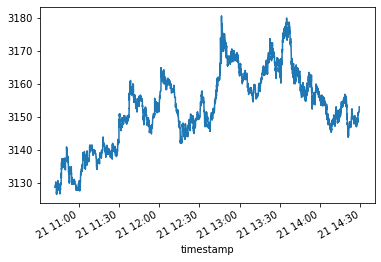

In [41]:
# sim.trade_hist
full_df.bid1_price.plot()

<AxesSubplot:xlabel='timestamp'>

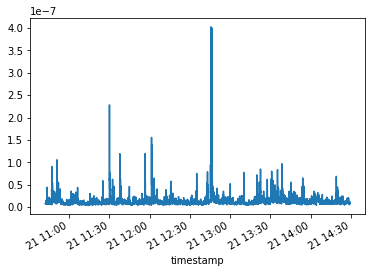

In [42]:
full_df["prediction_vol"].plot()

In [56]:
full_df["ask_fill"]

timestamp
2022-04-21 10:42:25    NaN
2022-04-21 10:42:26    NaN
2022-04-21 10:42:27    NaN
2022-04-21 10:42:28    NaN
2022-04-21 10:42:29    NaN
                      ... 
2022-04-21 14:29:08    NaN
2022-04-21 14:29:09   -1.0
2022-04-21 14:29:10    NaN
2022-04-21 14:29:11   -1.0
2022-04-21 14:29:12    NaN
Name: ask_fill, Length: 13134, dtype: float64

In [88]:
m_ask = res["max_ask"].iloc[-4]
q = res["ask_quote"].iloc[-4]


In [89]:
m_ask, q

(3153.1, 3153.05)